#Paquetes necesarios

In [18]:
import cv2
import os
import glob
import math
import numpy as np
import tkinter as tk
import matplotlib.pyplot as plt
from threading import Thread
import random
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

TAREA: Captura una o varias imágenes con monedas no solapadas y algún objeto que no lo sea. Filtra los contornos que no se correpondan con monedas, y muestra el número total de monedas presentes en la imagen.

Primero selecciona una moneda


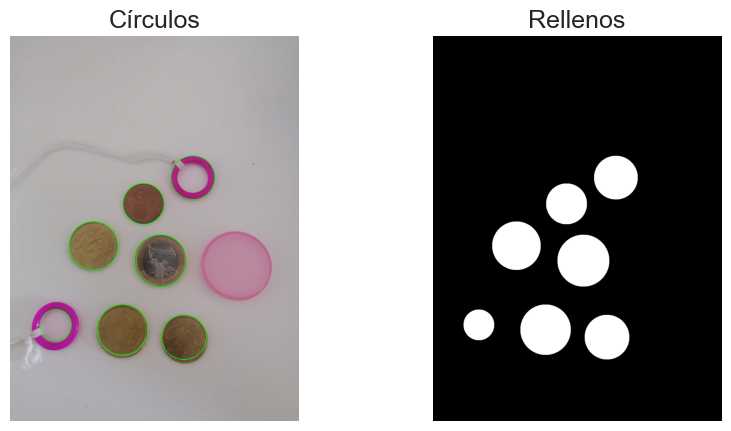

In [15]:
def procesar_imagen():
    """
    Procesa la imagen redimensionada para detectar y dibujar círculos con radios reales.    
    """
    global img_redimensionada
    try:
        gris = cv2.cvtColor(img_redimensionada, cv2.COLOR_BGR2GRAY)
        pimg = cv2.medianBlur(gris, 7)
        radio_min_px = list(monedas_reales.keys())[-1] - 5
        radio_min_px = int(np.floor(radio_min_px/factor_conversion))
        radio_max_px = list(monedas_reales.keys())[0] + 5
        radio_max_px = int(np.ceil(radio_max_px / factor_conversion))
        # Detectar círculos con radios reales
        circulos = detectar_circulos_con_radios_reales(circ, radio_min_px, radio_max_px)

        if circulos:
            dibujar_circulos_en_imagen(circulos, radio_min_px, radio_max_px)

    except Exception as e:
        print("Error en procesar_imagen:", e)


def dibujar_circulos_en_imagen(circulos, radio_min_px, radio_max_px):
    """
    Dibuja los círculos detectados en la imagen y muestra el resultado.

    Parámetros:
    -----------
    circulos : list of tuples
        Lista de tuplas (x, y, radio) que representan los círculos detectados.
    
    Muestra la imagen con los círculos dibujados.
    """
    global img_rgb, img_cont
    try:
        for det in circulos:
            x_coor, y_coor, det_radio = det
            #if radio_min_px < det_radio < radio_max_px: 
            cv2.circle(img_rgb, (int(x_coor), int(y_coor)), int(det_radio), (0, 255, 0), 2)
            cv2.circle(img_cont, (int(x_coor), int(y_coor)), int(det_radio), (255, 255, 255), -1)
        # Mostrar la imagen con los círculos dibujados usando Matplotlib
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.axis("off")
        imagen_normalizada = img_rgb / 255.0
        plt.imshow(imagen_normalizada)
        plt.title('Círculos')

        plt.subplot(122)
        plt.axis("off")
        imagen_normalizada = img_cont / 255.0
        plt.imshow(imagen_normalizada)
        plt.title('Rellenos')
        plt.show()
    except Exception as e:
        print("Error en dibujar_circulos_en_imagen:", e)

def detectar_circulos_con_radios_reales(circulos_previos, radio_min_px, radio_max_px):
    """
    Filtra los círculos detectados para obtener aquellos con radios dentro de un rango específico.

    Parámetros:
    -----------
    circulos_previos : list of tuples
        Lista de tuplas (x, y, radio) que representan los círculos detectados previamente.
    radio_min : int
        Valor mínimo del radio permitido.
    radio_max : int
        Valor máximo del radio permitido.

    Devuelve:
    -----------
    list of tuples
        Lista de tuplas (x, y, radio) que representan los círculos filtrados.
    """
    circulos_filtrados = []
    circ_final = cv2.HoughCircles(
        pimg,  # imagen 
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1,
        100,  # distancia mínima entre círculos
        param1=100, # Valor del gradiente
        param2=50, #Umbral acumulador
        minRadius=radio_min_px,  # radio mínimo
        maxRadius=radio_max_px,  # radio máximo
    )
    try:
        for det in circ_final[0]:
            x_coor, y_coor, det_radio = det
            if radio_min_px <= det_radio <= radio_max_px:
                circulos_filtrados.append((x_coor, y_coor, det_radio))
        return circulos_filtrados
    except Exception as e:
        print("Error en detectar_circulos_con_radios_reales:", e)
        return []  # Retorna una lista vacía en caso de error


def calcular_factor_conversion():
    """
    Calcula el factor de conversión y procesa la imagen si los radios seleccionado y real están definidos.
    """
    global radio_seleccionado, radio_real, factor_conversion

    try:
        if radio_seleccionado is not None and radio_real is not None:
            factor_conversion = radio_real / radio_seleccionado
            procesar_imagen()  # Llamamos a la función para procesar la imagen
        if radio_seleccionado is None:
            print("Primero haz clic dentro de ella")
        if radio_real is None:
            print("Primero selecciona una moneda")
    except Exception as e:
        print("Error en calcular_factor_conversion:", e)


def mostrar_moneda(indice):
    """
    Muestra la moneda seleccionada y calcula el factor de conversión.

    Parámetros:
    -----------
    indice : int
        Índice de la moneda seleccionada en la lista de monedas españolas.
    """
    global moneda_seleccionada, radio_real, radio_seleccionado

    try:
        moneda_seleccionada = monedas_espanolas[indice]
        radio_real = list(monedas_reales.keys())[indice]
        # Calcular el factor de conversión
        calcular_factor_conversion()
    except Exception as e:
        print("Error en mostrar_moneda:", e)

def iniciar_gui():
    """
    Inicia la interfaz gráfica para seleccionar una moneda.
    """
    global moneda_seleccionada
    try:
        # Crear la ventana principal
        ventana = tk.Tk()
        ventana.title('Monedas Españolas')
        # Crear botones para cada moneda
        for indice, moneda in enumerate(monedas_espanolas):
            boton = tk.Button(ventana, text=moneda, command=lambda i=indice: mostrar_moneda(i))
            boton.pack(pady=5)
        # Iniciar el bucle principal de la aplicación
        ventana.mainloop()
    except Exception as e:
        print("Error en iniciar_gui:", e)

def esta_dentro_del_circulo(x_clic, y_clic, x_circulo, y_circulo, radio):
    """
    Verifica si un punto está dentro del círculo.

    Parámetros:
    -----------
    x_clic : float
        Coordenada x del punto.
    y_clic : float
        Coordenada y del punto.
    x_circulo : float
        Coordenada x del centro del círculo.
    y_circulo : float
        Coordenada y del centro del círculo.
    radio : float
        Radio del círculo.

    Devuelve:
    -----------
    bool
        True si el punto está dentro del círculo, False en caso contrario.
    """
    distancia = math.sqrt((x_clic - x_circulo)**2 + (y_clic - y_circulo)**2)
    return distancia <= radio

def obtener_posicion(event, x, y, flag, param):
    """
    Obtiene la posición del clic y verifica si está dentro de algún círculo.

    Parámetros:
    -----------
    event : int
        Tipo de evento (en este caso, el clic del mouse).
    x : int
        Coordenada x del clic.
    y : int
        Coordenada y del clic.
    flag : int
        Bandera asociada al evento.
    param : any
        Parámetro adicional (no se utiliza en esta función).
    """
    global img_redimensionada, radio_seleccionado, radio_real
    try:
        if event == cv2.EVENT_LBUTTONDOWN:
            # Convertir las coordenadas del clic a las coordenadas de la imagen original
            x_original = int((x / nuevo_ancho) * ancho)
            y_original = int((y / nuevo_alto) * alto)
            # Verificar si el clic está dentro de algún círculo
            for det in circ[0]:
                x_coor, y_coor, det_radio = det
                if esta_dentro_del_circulo(x_original, y_original, x_coor, y_coor, det_radio):
                    radio_seleccionado = det_radio    
                    # Calcular el factor de conversión
                    calcular_factor_conversion()
                    # Deshabilitar el cv2.setMouseCallback
                    cv2.setMouseCallback('Moneda 1', lambda *args : None)
                    break
    except Exception as e:
        print("Error en obtener_posicion:", e)

# Inicialización de variables globales
radio_seleccionado = None  # El radio de la moneda seleccionada
radio_real = None  # El radio real de la moneda seleccionada
monedas_espanolas = ['2 euros', '50 céntimos', '5 céntimos', '20 céntimos', '1 euro', '10 céntimos', '2 céntimos', '1 céntimo']  # Lista de denominaciones de monedas
monedas_reales = {25.75: '2 euros', 24.25: '50 céntimos', 21.25: '5 céntimos', 22.25: '20 céntimos', 23.25: '1 euro', 19.75: '10 céntimos', 18.75: '2 céntimos', 16.25: '1 céntimo'}  # Diccionario de radios reales de monedas

# Iniciar la GUI en un hilo separado
moneda_seleccionada = None
gui_thread = Thread(target=iniciar_gui)
gui_thread.start()

# Cargar imagen de la plantilla de monedas
img_plantilla = cv2.imread('./Images/Class/Monedas.jpg') 
#Conversión a gris
gris_plantilla = cv2.cvtColor(img_plantilla, cv2.COLOR_BGR2GRAY)
#Suaviza altas frecuencias
pimg_plantilla = cv2.medianBlur(gris_plantilla, 7)

# Localiza Círculos en la plantilla de monedas
circ_plantilla = cv2.HoughCircles(
        pimg_plantilla,  # imagen 
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1,
        100,  # distancia mínima entre círculos
        param1=100, # Valor del gradiente
        param2=50, #Umbral acumulador
        minRadius=50,  # radio mínimo
        maxRadius=150,  # radio máximo
    )

# Almacena los radios de la plantilla
radios = []
#Dibuja sobre entrada  e imagen vacía
img_rgb_plantilla = cv2.cvtColor(img_plantilla, cv2.COLOR_BGR2RGB)
img_cont_plantilla = np.zeros(img_rgb_plantilla.shape)

for det in circ_plantilla[0]:
        x_coor, y_coor, det_radio = det
        radios.append(det_radio)
        cv2.circle(img_cont_plantilla,(int(x_coor), int(y_coor)),
            int(det_radio),(255, 255, 255), -1)
        
# Establecer radio mínimo y máximo en función de la plantilla
radio_min = int(np.floor(np.min(radios))) -5 
radio_max = int(np.ceil(np.max(radios))) + 5

# Cargar imagen de monedas a analizar
img = cv2.imread('./Images/monedas_tarea1.jpg') 
#Conversión a gris
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#Suaviza altas frecuencias
pimg = cv2.medianBlur(gris, 7)

# Localiza Círculos en la imagen de monedas
circ = cv2.HoughCircles(
    pimg,  # imagen 
    cv2.HOUGH_GRADIENT,  # tipo de detección
    1,
    100,  # distancia mínima entre círculos
    param1=100, # Valor del gradiente
    param2=50, #Umbral acumulador
    minRadius=radio_min,  # radio mínimo
    maxRadius=radio_max,  # radio máximo
)
#Dibuja sobre entrada  e imagen vacía
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_cont = np.zeros(img_rgb.shape)
for det in circ[0]:
        x_coor, y_coor, det_radio = det

alto, ancho = img.shape[:2]
nuevo_alto = 700
nuevo_ancho = int((nuevo_alto / alto) * ancho)
img_redimensionada = cv2.resize(img, (nuevo_ancho, nuevo_alto))

# Mostrar la imagen
cv2.imshow('Moneda 1', img_redimensionada)

# Vincular la función de clic a la ventana
cv2.setMouseCallback('Moneda 1', obtener_posicion)

# Esperar a que se presione una tecla y luego cerrar la ventana
cv2.waitKey(0)
cv2.destroyAllWindows()

El código proporcionado utiliza el algoritmo de transformada de Hough para detectar círculos en imágenes de monedas. Sin embargo, existen algunas áreas donde se puede mejorar la eficiencia y la precisión de la detección de monedas. Aquí hay algunos puntos a considerar:
- Ajuste de Parámetros (param1 y param2, radio mínimo y máximo):
Se ha experimentado con diferentes valores de los parámetros nombrados para obtener los mejores resultados, haciendo uso de varias imágenes. Ya que es crucial para adaptar la deteeción a las caracterísiticas específicas de las imágenes. Con respecto a los radios, se ha hecho uso de los valores máximos y mínimos de la plantilla o de los valores de las monedas reales escaladas al tamaó de la imagen por factor de conversión.
- Falsos positivos:
Aún haciendo uso de la transformada de Hough, puede generar falsos positivos debido a variaciones de iluminación, ruido de la imagen y otras formas redondeadas que pueden confundirse con monedas.
- Redimensionamiento de imágenes:
Para poder trabajar con ella y seleccionar la moneda de referencia, se ha tenido que redimensionar la imagen. Sin embargo, esto puede afectar a la detección de círculos, ya que no se mantiene la calidad de los detalles.
-Detección de Monedas Solo por Bordes y HoughCircles:
Dependiendo de las imágenes, confiar únicamente en la detección de bordes y la transformada de Hough puede no ser suficiente para garantizar una detección precisa. Las monedas pueden tener irregularidades en los bordes y otras características que dificulten la detección mediante técnicas puramente geométricas.
Por lo tanto, combinar múltiples técnicas de procesamiento de imágenes, como umbralización adaptativa y técnicas de segmentación basada en el color, puede mejorar la precisión de la detección.

Documentación:
- https://docs.python.org/es/3/library/tkinter.html
- https://docs.opencv.org/4.x/da/d53/tutorial_py_houghcircles.html

TAREA: Captura una o varias imágenes con monedas no solapadas, y otras con monedas solapadas. Identificada una moneda de un euro en la imagen, por ejemplo con un clic de ratón, calcular la cantidad de dinero presente en la imagen. ¿Qué problemas han observado?




Number of coins: 18
Value of coins: [2.0, 2.0, 2.0, 2.0, 1.0, 0.5, 2.0, 1.0, 1.0, 0.1, 0.5, 2.0, 1.0, 2.0, 2.0, 2.0, 0.05, 1.0]
Total value: 24.15
Diameter of the selected coin: 23.47 px
Value of the selected coin: 1.0 €
-----------------------------------------------------------
Diameter of the selected coin: 20.56 px
Value of the selected coin: 0.05 €
-----------------------------------------------------------
Diameter of the selected coin: 19.90 px
Value of the selected coin: 0.1 €
-----------------------------------------------------------


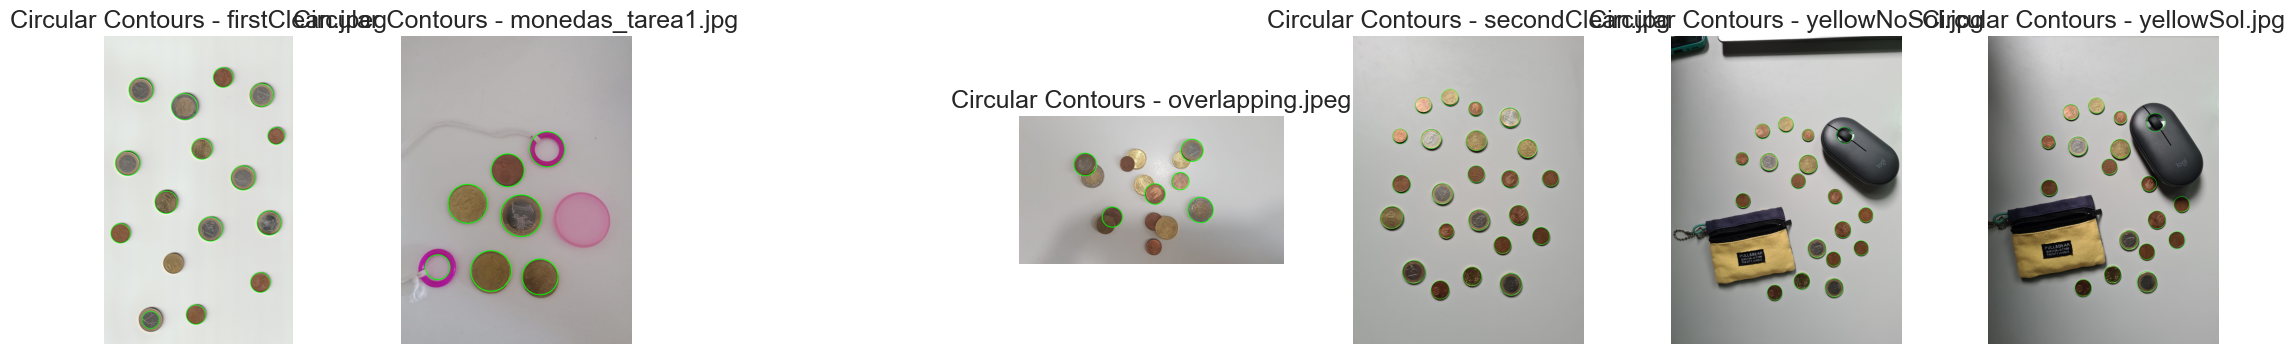

In [37]:
def load_and_preprocess_image(image_path):
    '''
    Load and preprocess the input image
    '''
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    smoothed_img = cv2.medianBlur(gray, 7)
    return img, smoothed_img


def detect_circles(image, smoothed_image):
    '''
    Detect circles in the preprocessed image
    '''
    circ = cv2.HoughCircles(
        smoothed_img,        # Image
        cv2.HOUGH_GRADIENT,  # Detection method
        1,
        100,                 # Minimum distance between circles
        param1=100,          # Gradient value
        param2=54,           # Accumulator threshold
        minRadius=50,        # Minimum radius
        maxRadius=150        # Maximum radius
    )
    return circ


def draw_circles_on_image(image, circles):
    '''
    Draw circles on the image
    '''
    img_rgb_circles = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).copy()
    for det in circles[0]:
        x_coord, y_coord, det_radius = int(det[0]), int(det[1]), int(det[2])
        cv2.circle(img_rgb_circles, (x_coord, y_coord),
                   det_radius, (0, 255, 0), 3)  # Draw circles with green color
    return img_rgb_circles

def coin_selection(event, x, y, flags, param):
    global coin_info_printed
    global coin_values

    if event == cv2.EVENT_LBUTTONDOWN:
        coin_diameters = []

        for i, det in enumerate(circ[0]):
            (center_x, center_y), radius = (int(det[0]), int(det[1])), int(det[2])
            distance = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)

            if distance < radius:
                diameter = 2 * radius
                scale = 24.25 / diameter
                num_coins = len(circ[0])

                for j in range(num_coins):
                    coin_diameter = 2 * circ[0][j][2]
                    coin_diameters.append(coin_diameter)

                for k in range(num_coins):
                    coin_diameters[k] *= scale

                values_corresponding = []
                for diameter in coin_diameters:
                    nearest_scale = min(coin_values, key=lambda x: abs(x - diameter))
                    corresponding_value = coin_values[nearest_scale]
                    values_corresponding.append(corresponding_value)

                if not coin_info_printed:
                    print(f"Number of coins: {num_coins}")
                    print(f"Value of coins: {values_corresponding}")
                    print(f"Total value: {sum(values_corresponding):.2f}")
                    print("========================================================")
                    coin_info_printed = True

                print(f"Diameter of the selected coin: {diameter:.2f} px")
                print(f"Value of the selected coin: {corresponding_value} €")
                print("-----------------------------------------------------------")

                break
            
# Define coin values (diameter in mm : coin value)
coin_values = {
    16.26: 0.01,
    18.75: 0.02,
    21.25: 0.05,
    19.75: 0.1,
    22.25: 0.2,
    24.25: 0.5,
    23.25: 1.0,
    25.75: 2.0
}

# Get images from path folder
image_folder = './Images/'
image_files = os.listdir(image_folder)

processing_clickable_image = False

# Determine the number of columns for subplot layout
num_cols = len(image_files) - 1  # Excluding the first image
num_rows = 1

# Create a figure for the subplots
fig = plt.figure(figsize=(4 * num_cols, 4))
plt.subplots_adjust(wspace=0.2)  # Adjust the space between subplots

for idx, image_file in enumerate(image_files[1:], start=1):
    image_path = os.path.join(image_folder, image_file)  # Full path to the image

    if image_file == 'Outputs':
        continue

    img, smoothed_img = load_and_preprocess_image(image_path)
    circ = detect_circles(img, smoothed_img)

    # Draw circles on the image
    img_rgb_circles = draw_circles_on_image(img, circ)

    if image_file == 'yellowSol.jpg':
        processing_clickable_image = True

    if processing_clickable_image:
        # Create a window for coin selection
        cv2.namedWindow('Select a coin', cv2.WINDOW_NORMAL)
        cv2.resizeWindow('Select a coin', 800, 800)

        # Display the image with circles
        cv2.imshow('Select a coin', img_rgb_circles)

        # Initialize a flag to avoid printing duplicated info
        coin_info_printed = False

        # Set up mouse callback for coin selection
        cv2.setMouseCallback('Select a coin', coin_selection)

        while True:
            cv2.imshow('Select a coin', img_rgb_circles)
            key = cv2.waitKey(1) & 0xFF
            if key == 27 or key == ord('q'):  # ESC or q to exit
                break

        cv2.destroyAllWindows()

    # Add the subplot for the image
    ax = fig.add_subplot(num_rows, num_cols, idx)
    ax.imshow(img_rgb_circles)
    ax.axis("off")
    ax.set_title(f'Circular Contours - {image_file}')

# Display the subplots
plt.show()

Problemas detectados:
- Falta de consideración de características específicas de las monedas -> el código se basa únicamente en el tamaño de los círculos detectados en la imagen para asignar un valor de moneda. Esto significa que no tiene en cuenta las características visuales específicas de las monedas, como su diseño, texto, marcas o cualquier otra característica distintiva que podría ayudar a identificar la moneda de manera precisa y confiable.
- Incapacidad para distinguir entre monedas con diámetros similares -> cuando se trata de monedas con diámetros cercanos o idénticos, como el caso de las monedas de 1 euro y 2 céntimos, que pueden tener diámetros similares dependiendo de la distancia en la imagen, el código no puede diferenciarlas de manera efectiva y asigna el mismo valor basado únicamente en el diámetro, lo que conduce a evaluaciones incorrectas.
- Falta de distinción entre objetos y monedas -> el código no es capaz de distinguir entre objetos circulares que no son monedas y las verdaderas monedas. Esto puede resultar en falsos positivos, ya que cualquier objeto circular en la imagen será interpretado como una moneda y se le asignará un valor, lo que puede llevar a evaluaciones incorrectas o inexactas de lo que realmente es una moneda.
- Limitaciones en la detección de monedas solapadas -> el código experimenta dificultades al identificar monedas que se solapan parcialmente en la imagen. El solapamiento de monedas puede llevar a que algunas partes de las monedas no sean detectadas o que se les asigne un valor incorrecto debido a la falta de visibilidad completa. Esta limitación puede resultar en evaluaciones inexactas de las monedas superpuestas o a la falta de evaluación de las monedas en sí.

Documentación
- https://www.carm.es/web/pagina?IDCONTENIDO=718&IDTIPO=100&RASTRO=c285$m
- https://acodigo.blogspot.com/2017/09/deteccion-de-lineas-y-circulos-usando.html
- https://dev.to/tinazhouhui/coin-amount-calculation-discovering-opencv-with-python-52gn

TAREA: Estas tres imágenes han sido extraidas de las imágenes de mayor tamaño contenidas en la carpeta. Determina patrones geométricos para cada una de las tres clases y evalúa los aciertos y fallos con las imágenes completas la matriz de confusión. Para cada clase, determina el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifica incorrectamente por cada una de las otras dos clases.

El el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas en dicho trabajo fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación del cuadrado del perímetro con el área)
- Relación del área con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

Las métricas se utilizan para mostrar la bondad de un clasificador, la siguiente celda obtiene varias para un conjunto de datos imaginario (y con etiquetas aleatorias). Si bien las trataremos con más detalle en teoría, muestro un repertorio de ellas, dando más peso a la matriz de confusión.

¿Qué es una matriz de confusión?
Se utiliza para mostrar el comportamiento de un clasificador par alas distintas clases consideradas, se relacionan las etiquetas de las muestras anotadas frente a las predichas por el clasificador. Se busca una matriz diagonal, pero la perfección es infrecuente

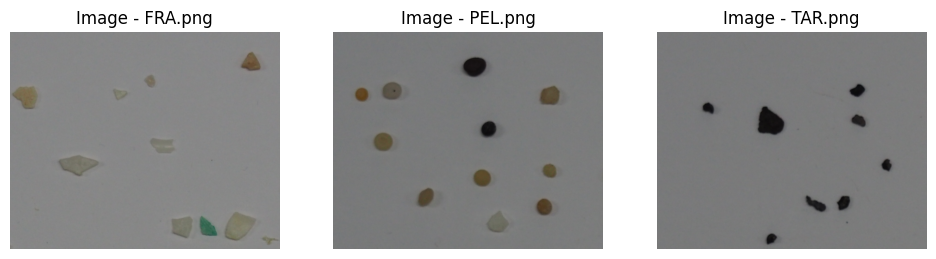

In [135]:
# Get images from path folder
image_folder = './Images/Class/'
image_files = glob.glob(os.path.join(image_folder, '*.png'))

# Determine the number of columns for subplot layout
num_cols = len(image_files) + 1  # Including the first image
num_rows = 1

# Create a figure for the subplots
fig = plt.figure(figsize=(4 * num_cols, 4))
plt.subplots_adjust(wspace=0.2)  # Adjust the space between subplots

for idx, image_file in enumerate(image_files, start=0):
    # Add the subplot for the image
    ax = fig.add_subplot(num_rows, num_cols, idx + 1)  # Sumar 1 al índice
    img_rgb = plt.imread(image_file)  # Load the image with matplotlib
    ax.imshow(img_rgb)
    ax.axis("off")
    image_file = os.path.basename(image_file)  # Get the file name
    ax.set_title(f'Image - {image_file}')

# Display the subplots
plt.show()

Detección de contornos

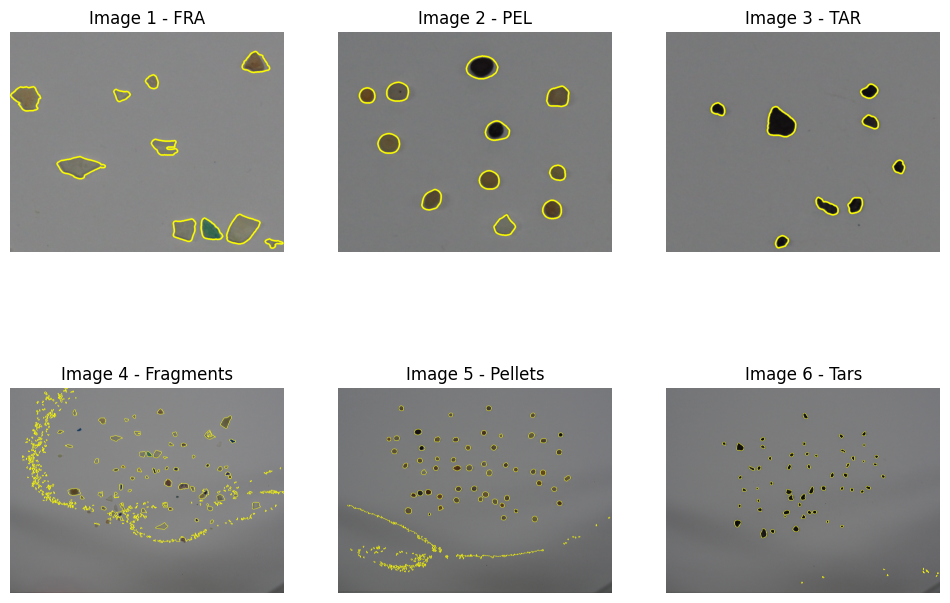

In [180]:
def process_image(image_path, threshold_value, blur_kernel, title):
    '''
    Process an image to detect and highlight specific contours based on the provided parameters
    '''
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, blur_kernel, 0)
    _, th = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)
    edges = cv2.Canny(th, 100, 200)

    contornos, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contornos_reales = []
    area_max = 0
    area_min = 0
    radio_fra = 0
    min_radio = 100
    media_rectangulos = []

    for cont in contornos:
        area = cv2.contourArea(cont)
        if area <= 200:
            continue

        x, y, w, h = cv2.boundingRect(cont)
        media_rectangulos.append((x + w) / (y + h))

        (x, y), radius = cv2.minEnclosingCircle(cont)
        center = (int(x), int(y))
        radius = int(radius)

        if radius > radio_fra:
            radio_fra = radius

        if radius < min_radio and radius > 5:
            min_radio = radius

        if area >= area_max:
            area_max = area

        if area >= 1000 and area < 2000:
            area_min = area

        (x, y), radius = cv2.minEnclosingCircle(cont)
        center = (int(x), int(y))
        radius = int(radius)

        if (x + w) / (y + h) >= 717:
            continue
        contornos_reales.append(cont)

    cv2.drawContours(img, contornos_reales, -1, (0, 255, 255), 5)
    return img

# Define image processing parameters
image_info = [
    ("./Images/Class/FRA.png", 130, (15, 15), "FRA"),
    ("./Images/Class/PEL.png", 110, (21, 21), "PEL"),
    ("./Images/Class/TAR.png", 100, (7, 7), "TAR"),
    ("./Images/Class/fragment-03-olympus-10-01-2020.JPG", 130, (15, 15), "Fragments"),
    ("./Images/Class/pellet-03-olympus-10-01-2020.JPG", 110, (21, 21), "Pellets"),
    ("./Images/Class/tar-03-olympus-10-01-2020.JPG", 100, (7, 7), "Tars"),
]

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
fig.subplots_adjust(hspace=0.3)

for i, info in enumerate(image_info):
    row = i // 3
    col = i % 3
    img = process_image(*info)
    axs[row, col].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[row, col].set_title(f"Image {i + 1} - {info[3]}")
    axs[row, col].axis("off")

plt.show()


Detección de fragmentos, bolas & alquitrán

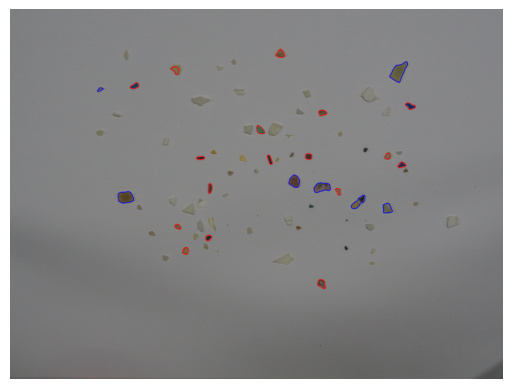

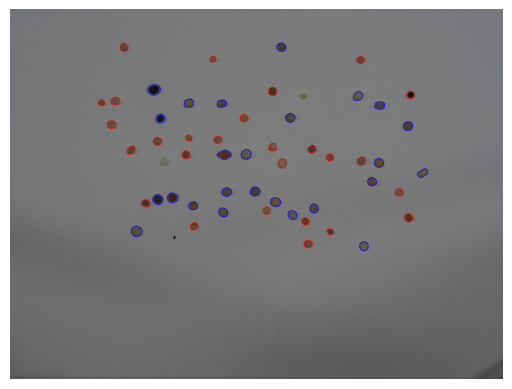

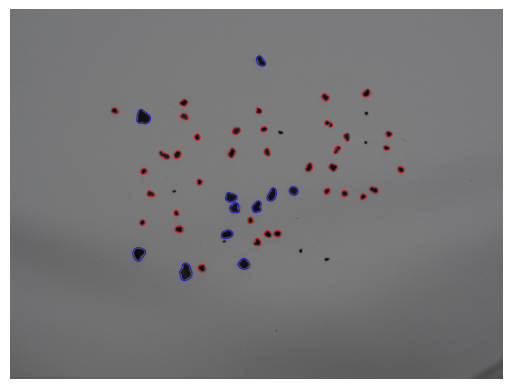

In [35]:
def process_image(img_path, threshold_value, min_radius, max_radius, true_class, fragment_labels, tar_labels, pellet_labels):
    '''
    Process an image to detect and classify contours based on specified criteria
    '''
    img = cv2.imread(img_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Blur the image to remove potential false contours
    blurred = cv2.GaussianBlur(gray, (51, 51), 0)

    # Apply thresholding
    _, th = cv2.threshold(blurred, threshold_value, 255, cv2.THRESH_BINARY)

    # Apply Canny edge detection
    img_canny = cv2.Canny(th, 100, 200)

    # Get the contours in the image
    contours, _ = cv2.findContours(img_canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize lists to store different types of contours
    fragment = []
    pellet = []
    tar = []

    for contour in contours:
        area = cv2.contourArea(contour)

        # Skip small contours with less than 5 points
        if len(contour) < 5:
            continue

        # Fit an ellipse to the contour
        ((centx, centy), (width, height), angle) = cv2.fitEllipse(contour)

        x, y, w, h = cv2.boundingRect(contour)

        # Calculate the focal distances of the ellipse
        ellipse_focal_distances = (abs(np.sqrt((height)**2 - (width)**2))) * 2

        # Find the minimum enclosing circle
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)

        # Classify contours into fragment, pellet, or tar based on criteria
        if area <= 600:
            continue

        if area <= 5000 and radius >= min_radius and radius <= max_radius:
            pellet.append(contour)
            pellet_labels.append(true_class)
            continue

        if area >= 5000 or ellipse_focal_distances >= 90:
            fragment.append(contour)
            fragment_labels.append(true_class)
            continue

        if min_radius <= radius <= max_radius:
            tar.append(contour)
            tar_labels.append(true_class)
            continue

    # Draw contours on the image
    cv2.drawContours(img, fragment, -1, (255, 0, 0), 5)  # Fragments = red
    cv2.drawContours(img, pellet, -1, (0, 0, 255), 5)  # Pellets = blue
    cv2.drawContours(img, tar, -1, (255, 255, 0), 5)  # Tar = yellow

    # Display the processed image
    plt.axis("off")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
    plt.show()

fragment_labels = []
pellet_labels = []
tar_labels = []

process_image("./Images/Class/fragment-03-olympus-10-01-2020.JPG", 110, 28, 57, "fragment", fragment_labels, tar_labels, pellet_labels)
process_image("./Images/Class/pellet-03-olympus-10-01-2020.JPG", 100, 28, 57, "pellet", fragment_labels, tar_labels, pellet_labels)
process_image("./Images/Class/tar-03-olympus-10-01-2020.JPG", 100, 28, 57, "tar", fragment_labels, tar_labels, pellet_labels)

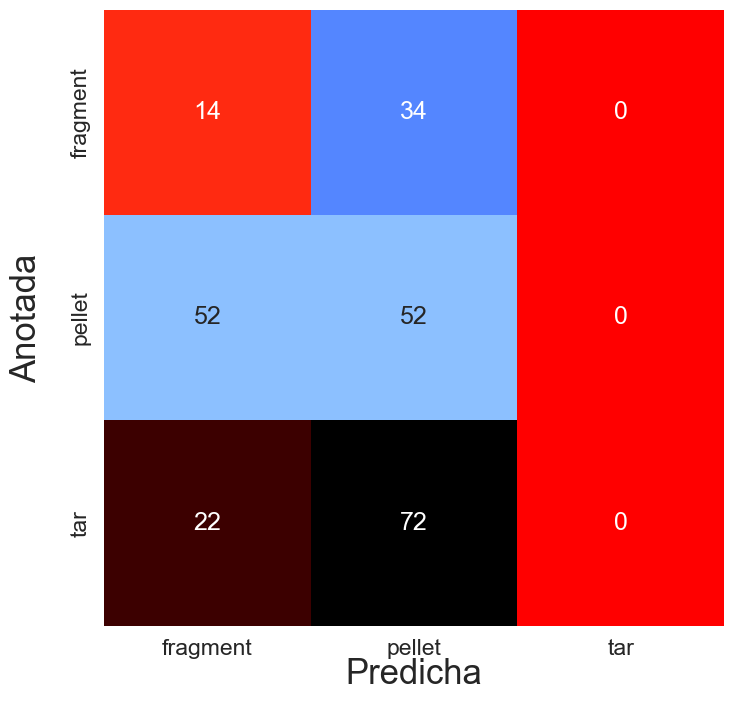

In [33]:
# Obtén las etiquetas reales y predichas
# Obtén las etiquetas reales y predichas
y_true = fragment_labels + pellet_labels + tar_labels
y_pred = ["fragment"] * len(fragment_labels) + ["pellet"] * len(pellet_labels) + ["tar"] * len(tar_labels)

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred, labels=["fragment", "pellet", "tar"])

# Visualiza la matriz de confusión
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.5)

ax = sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cbar=False,
    cmap='flag',
    xticklabels=["fragment", "pellet", "tar"],
    yticklabels=["fragment", "pellet", "tar"]
)

# Etiquetas de la matriz de confusión
label_font = {'size': '25'}
ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
ax.set_ylabel("Anotada", labelpad=20, fontdict=label_font)

plt.show()

Problemas detectados:
- Detección incompleta de formas-> el código no puede detectar todas las formas de manera completamente precisa. La detección de contornos puede verse afectada por varios factores, como la calidad de la imagen, la iluminación y las características específicas de los objetos en la imagen.
- Ambigüedad en la clasificación -> aunque el código intenta clasificar los contornos como fragmentos, bolitas o alquitrán en función de ciertos criterios, estos criterios pueden no ser suficientes para proporcionar una clasificación definitiva. Los objetos con tamaños o formas similares son clasificados incorrectamente.

Documentación:
- https://stackoverflow.com/questions/72118665/particle-detection-with-python-opencv
- https://learnopencv.com/blob-detection-using-opencv-python-c/